In [205]:
using Revise
using CMF
using PyPlot
using DSP
using WAV
using Statistics
using JLD
include("./plot_settings.jl")

set_size

In [162]:
path = "../../data/ira_glass.wav"
s, fs = WAV.wavread(path);

# Downsample to 8 Khz
fs_new = 8e3
p = Int(round(fs / fs_new))
s = s[1:p:end];


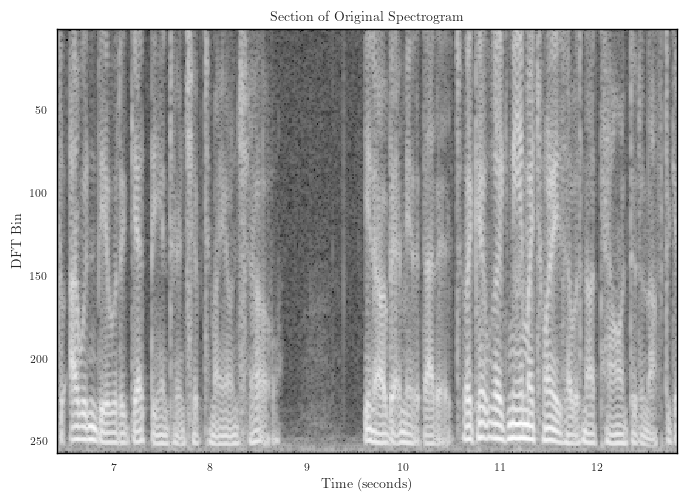

PyObject Text(0.5,1,'Section of Original Spectrogram')

In [152]:
# show section of spectrogram
start_idx = 400
end_idx = 800
S = spectrogram(s[:,1], 512, 384; window=hanning)
t = time(S)
f = freq(S)
data = log10.(S.power)
data = data .+ abs(minimum(data))

# Plot spectogram and label X axis with seconds
fig, ax = subplots()
ax.grid(false)
CMF.format_imshow_axis(ax; remove_ticks=false)
imshow(data[:,start_idx:end_idx], aspect="auto", origin="lower",
                extent=[t[start_idx]/fs_new, t[end_idx]/fs_new, size(data,1), 1], 
                cmap="gray")
ax.set_xlabel("Time (seconds)")
ax.set_ylabel("DFT Bin")
title("Section of Original Spectrogram")


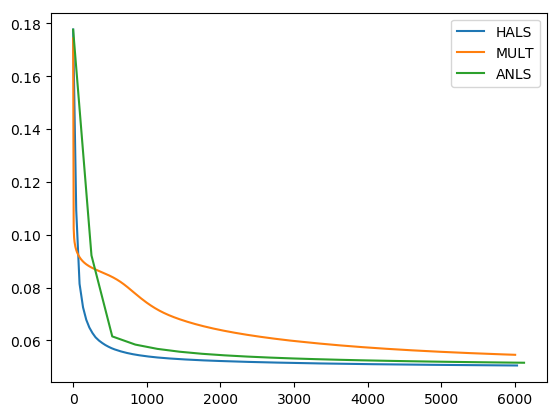

PyObject <matplotlib.legend.Legend object at 0x14f10c438>

In [170]:
alg_results = Dict()
figure()
for (alg, kwargs, label) in [
    [:hals, Dict(), "HALS"],
    [:mult, Dict(), "MULT"],
    [:anls, Dict(), "ANLS"],

]
    results = CMF.fit_cnmf(data; L=12, K=20,
    alg=alg, max_itr=Inf, max_time=1500,
                       check_convergence=false,
                       kwargs...
                       )

    plot(results.time_hist, results.loss_hist, label=label)
    alg_results[label] = results
end
legend()

In [155]:
#JLD.save("ira_glass_comparison.jld", alg_results)
results = JLD.load("ira_glass_comparison.jld");

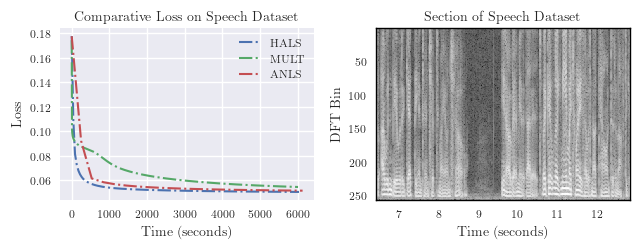

In [206]:
algs = ["HALS", "MULT", "ANLS"]
fig, ax = subplots(1,2, figsize=set_size(doc_textwidth; aspect=0.4))

# Show Image of dataset
ax1 = ax[2]
ax1.grid(false)
CMF.format_imshow_axis(ax1; remove_ticks=false)
imshow(data[:,start_idx:end_idx], aspect="auto", origin="lower",
extent=[t[start_idx]/fs_new, t[end_idx]/fs_new, size(data,1), 1], cmap="gray")
ax1.set_xlabel("Time (seconds)")
ax1.set_ylabel("DFT Bin")
title("Section of Speech Dataset")


#Show loss on speech dataset
ax2 = ax[1] 
for alg in algs
        r = results[alg]
        ax2.plot(
            r.time_hist, r.loss_hist,
            label=alg,
        )
end
ax2.set_xlabel("Time (seconds)")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.set_title("Comparative Loss on Speech Dataset")


plt.tight_layout()
plt.savefig("./fig2_panel_1_speech.pdf", format="pdf")

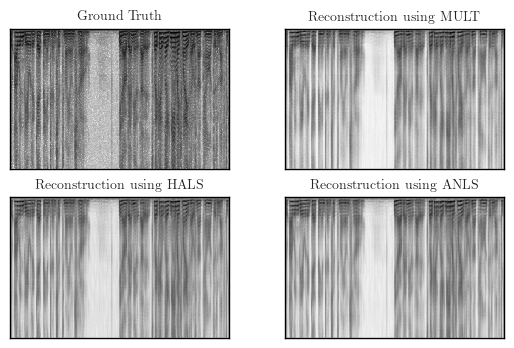

In [58]:
# For reconstructions and original data,
# we'll only show a subset of the data
start_idx = 400
end_idx = 800

fig, ax = subplots(2,2, figsize=set_size(doc_textwidth))

# Show Image of dataset
ax1 = ax[1]
CMF.format_imshow_axis(ax1)
ax1.imshow(results["HALS"].data[:,start_idx:end_idx])
ax1.set_title("Ground Truth")

for (i,a) in enumerate(ax[2:end])
    CMF.format_imshow_axis(a)
    alg = algs[i]
    r = results[alg]
    
    recon = CMF.tensor_conv(r.W, r.H)
    a.imshow(recon[:,start_idx:end_idx])
    a.set_title("Reconstruction using $alg")
end
plt.savefig("./reconstruction_comparison.pdf", format="pdf")

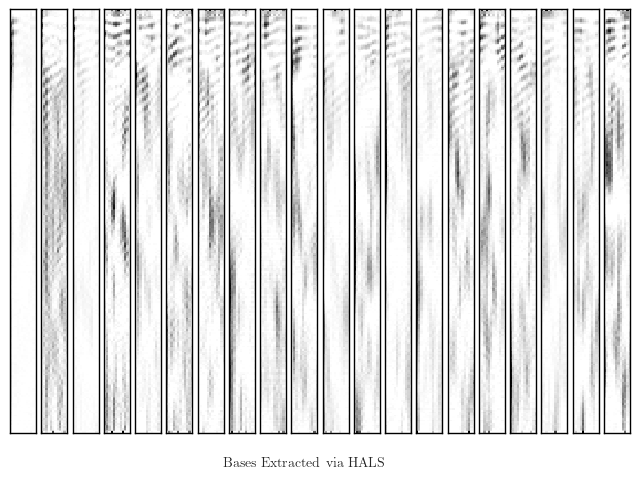

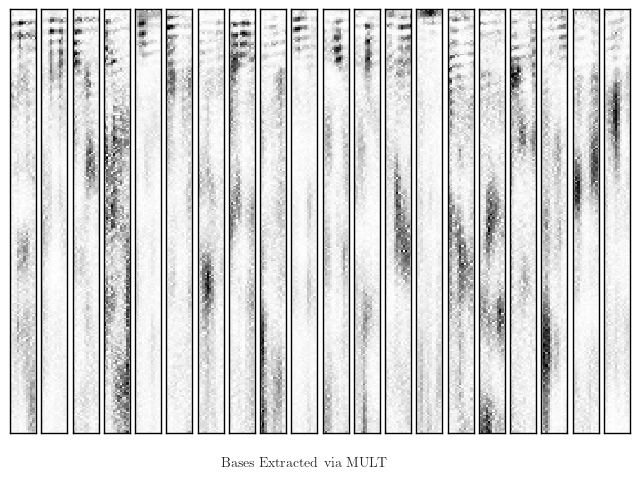

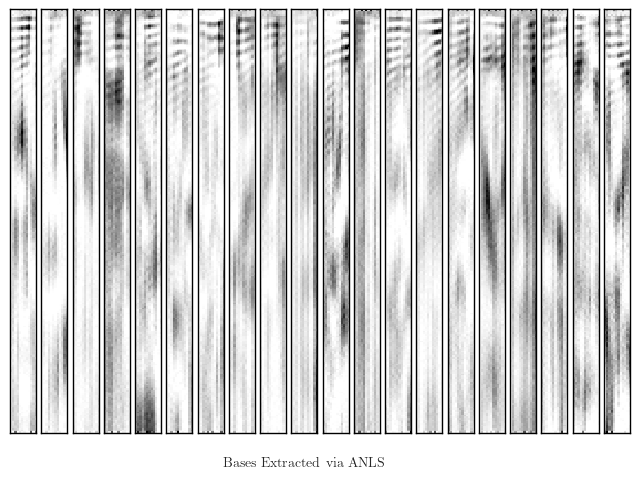

In [76]:
for alg in algs
    fig, ax = CMF.plot_Ws(results[alg], sort_units=false)
    ax_mid = ax[10]
    ax_mid.set_title("Bases Extracted via $alg", y=-0.1)
    plt.savefig("./extracted_basis_$alg.pdf", format="pdf")
end
